In [1]:
"https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html"

'https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/harmonization.html'

In [20]:
import sys

import pandas as pd
print(f"{pd.__version__=}")

import pytorch_lightning
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

import anndata as ad
import scanpy as sc
import scvi

pd.__version__='1.3.4'


In [3]:
# break

In [4]:
hypomap_reference = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/hypomap.h5ad"

# load the reference anndata
adata_ref = sc.read(hypomap_reference)

adata_ref = adata_ref.raw.to_adata() # recover raw counts

# assign the celltype from the cluster 25 column
adata_ref.obs["celltype"] = adata_ref.obs['C25_named'] # note that there are other cluster results in .obs
adata_ref.obs["batch"] = 'reference'
adata_ref.var_names = adata_ref.var['feature_name'] # set gene names as column headers

adata_ref

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(
/home/cstansbu/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['4933401J01Rik', 'Gm26206', 'Xkr4', 'Gm18956', 'Gm37180']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


AnnData object with n_obs × n_vars = 384925 × 51811
    obs: 'SRA_ID', 'Sample_ID', 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'Dataset', 'Batch_ID', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'C7_named', 'C25_named', 'C66_named', 'C185_named', 'C286_named', 'C465_named', 'Author_Class_Curated', 'Author_CellType', 'Region_summarized', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'celltype', 'batch'
    var: 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'schema_version', 'title'
    obsm: 'X_umap'

In [13]:
adata_ref.obs['broad_type'] = adata_ref.obs['C25_named'].apply(lambda x: x.split(":")[1].split("-")[0])

 GABA                 126617
 GLU                   92413
 Astrocytes            50656
 Oligodendrocytes      48722
 OPC                   21163
 Immune                14562
 Ependymal             14254
 Mural+Endothelial     14044
 Fibroblasts            1768
 ParsTuber               726
Name: broad_type, dtype: int64

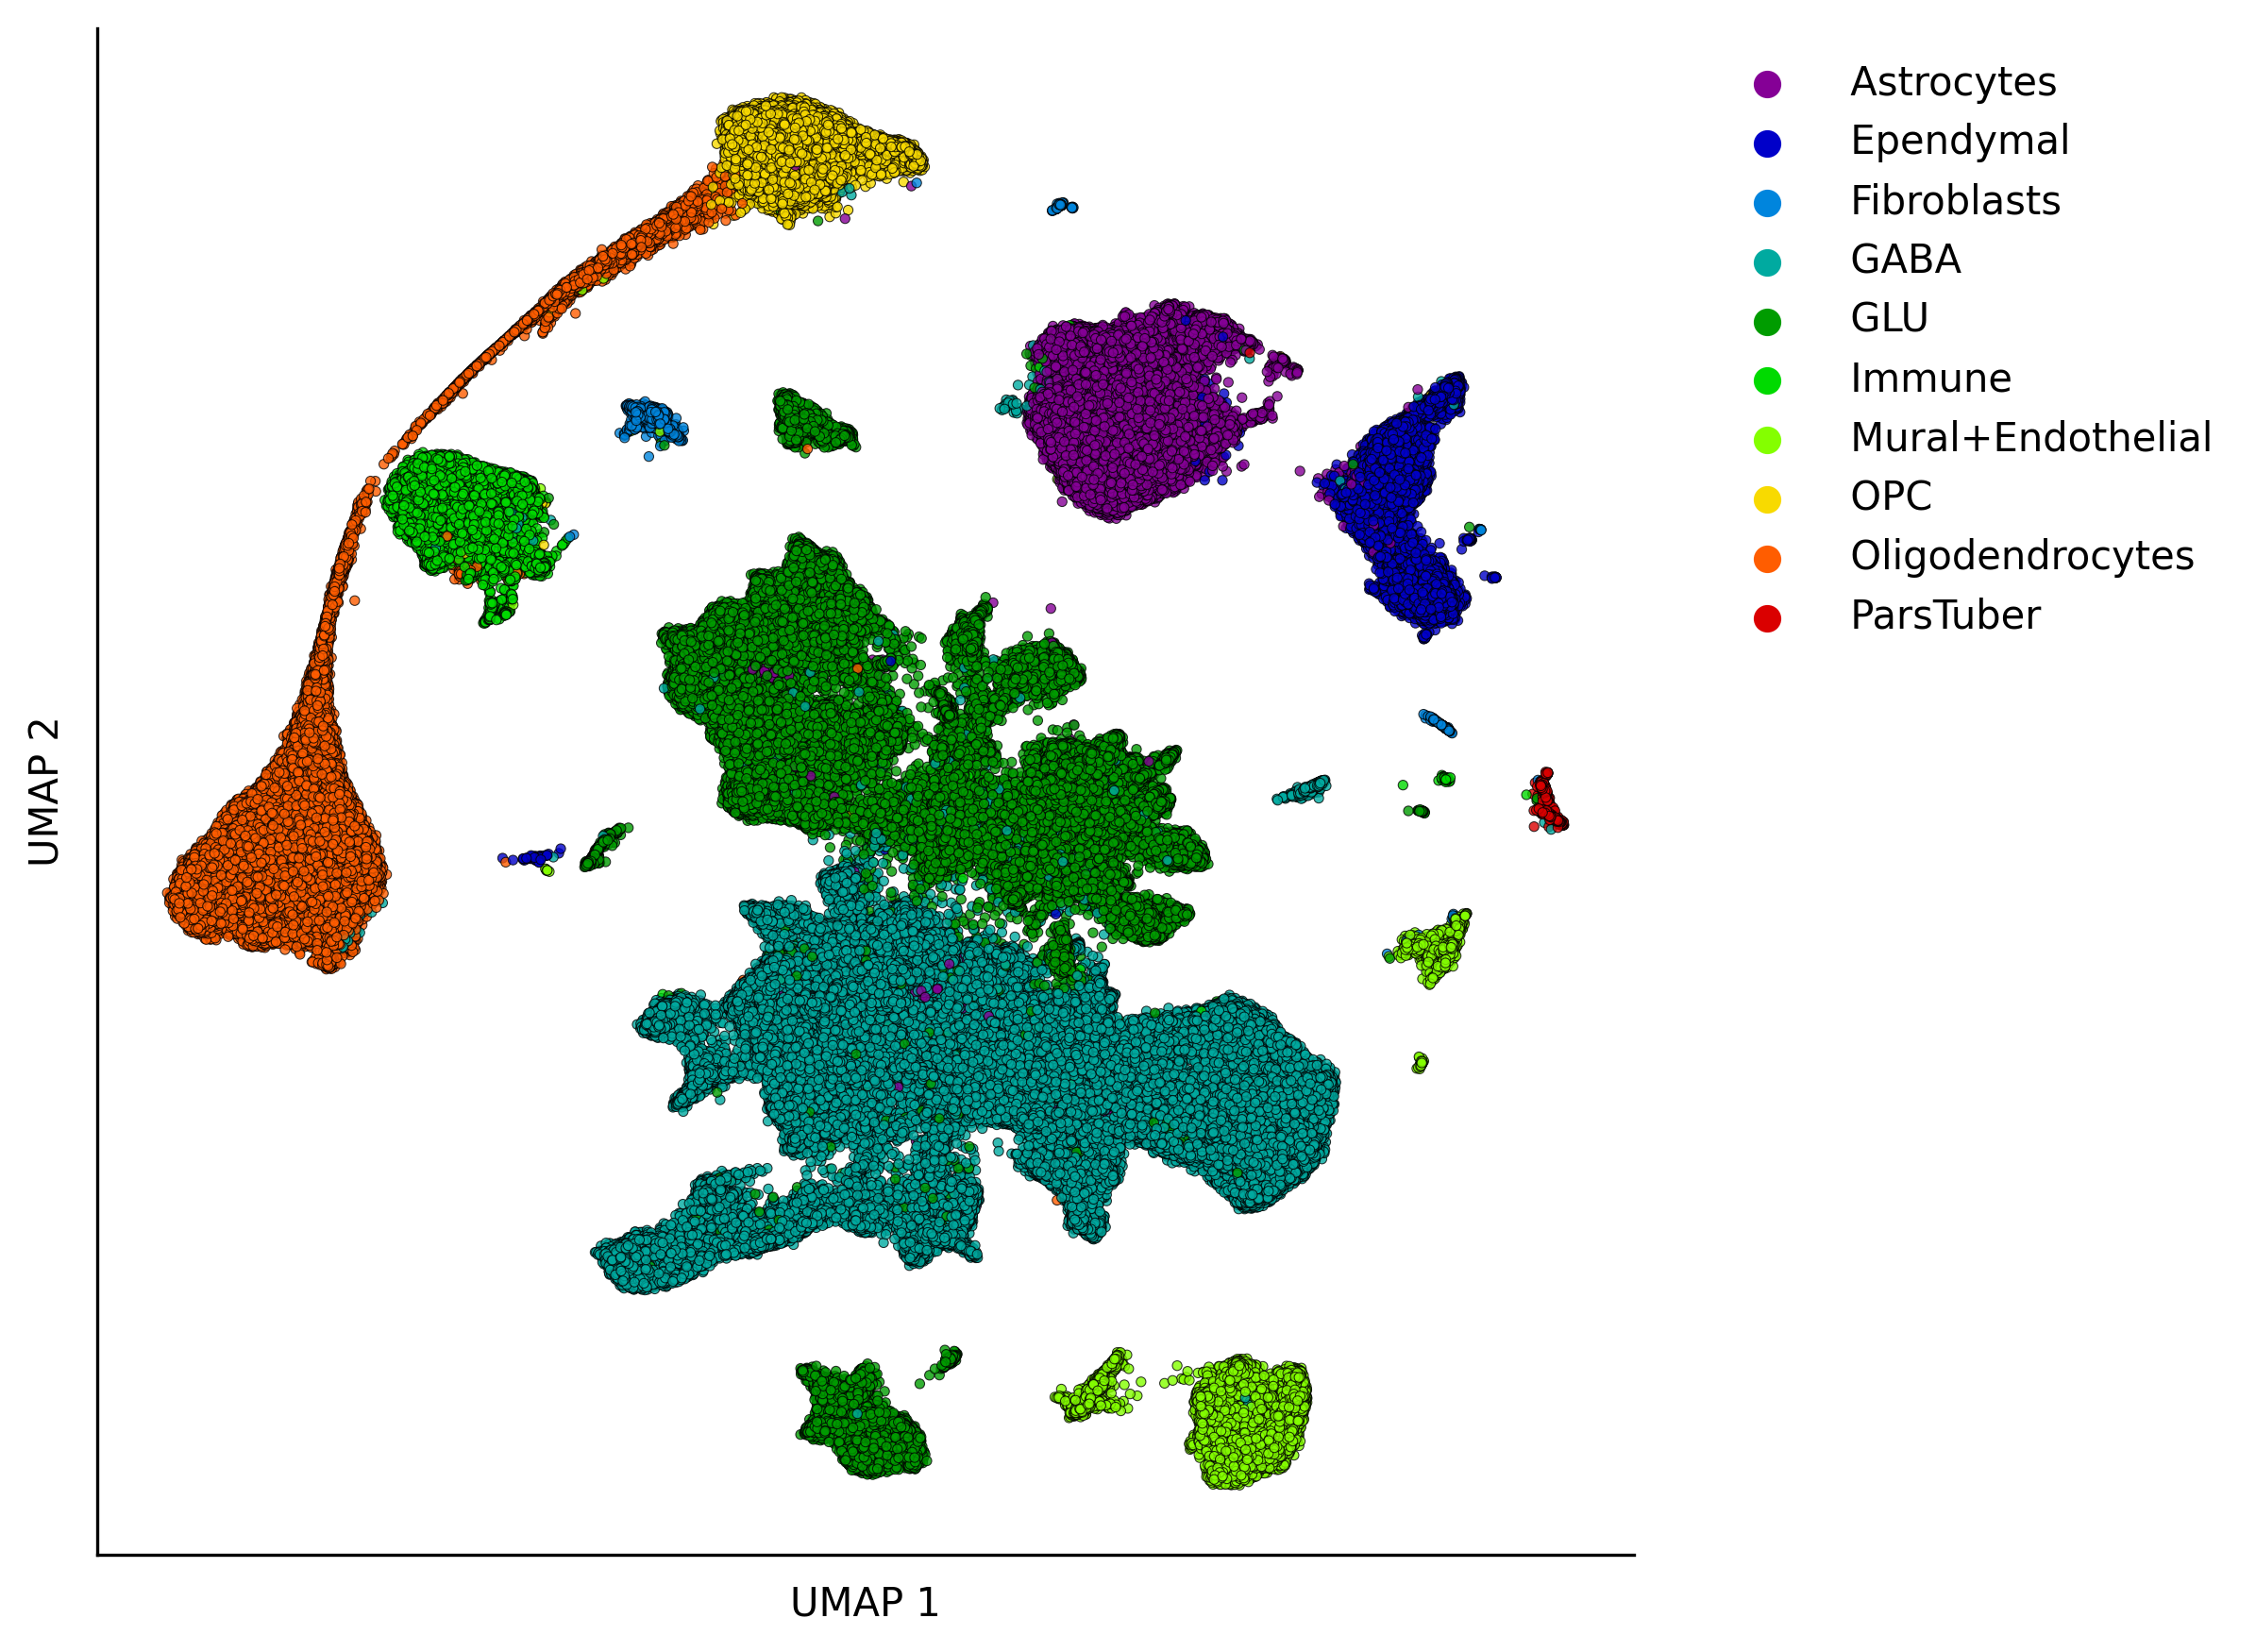

In [27]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.scatterplot(x=adata_ref.obsm['X_umap'][:, 0],
                y=adata_ref.obsm['X_umap'][:, 1],
                hue=adata_ref.obs['broad_type'],
                hue_order=sorted(adata_ref.obs['broad_type'].unique()),
                palette='nipy_spectral',
                ec='k',
                linewidth=0.25,
                alpha=0.8,
                s=6)

plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

plt.yticks([])
plt.xticks([])

sns.move_legend(plt.gca(),
                title='',
                frameon=False,
                loc='upper right',
                bbox_to_anchor=(1.4, 1))
sns.despine()


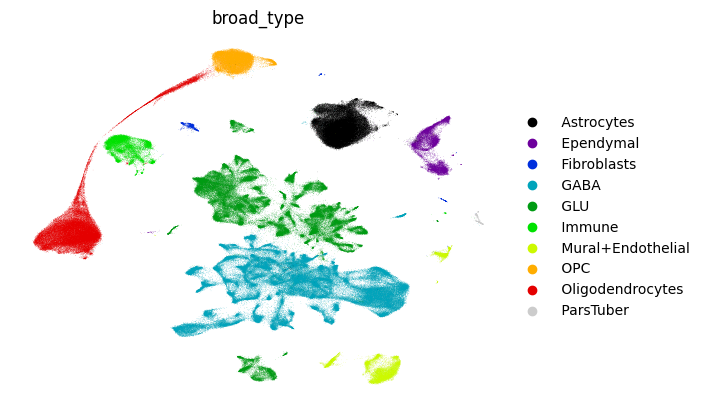

In [17]:
# plot the UMAP
sc.pl.umap(
    adata_ref,
    color=['broad_type'],
    palette='nipy_spectral',
    frameon=False,
    ncols=1,
)

In [7]:
?sc.pl.umap

Signature:
sc.pl.umap(
    adata: anndata._core.anndata.AnnData,
    *,
    color: Union[str, Sequence[str], NoneType] = None,
    gene_symbols: Optional[str] = None,
    use_raw: Optional[bool] = None,
    sort_order: bool = True,
    edges: bool = False,
    edges_width: float = 0.1,
    edges_color: Union[str, Sequence[float], Sequence[str]] = 'grey',
    neighbors_key: Optional[str] = None,
    arrows: bool = False,
    arrows_kwds: Optional[Mapping[str, Any]] = None,
    groups: Optional[str] = None,
    components: Union[str, Sequence[str]] = None,
    dimensions: Union[Tuple[int, int], Sequence[Tuple[int, int]], NoneType] = None,
    layer: Optional[str] = None,
    projection: Literal['2d', '3d'] = '2d',
    scale_factor: Optional[float] = None,
    color_map: Union[matplotlib.colors.Colormap, str, NoneType] = None,
    cmap: Union[matplotlib.colors.Colormap, str, NoneType] = None,
    palette: Union[str, Sequence[str], cycler.Cycler, NoneType] = None,
    na_color: Union[str, 